### Section 2: Modeling and effect inference

In [1]:
library(tidyverse)
library(data.table)
library(DESeq2)
library(patchwork)
library(ggcorrplot)
library(ggpubr)

setwd("~/work/mpra-v2")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The fo

In [ ]:
oligoCountPath = 'data/1KG_bartenderOligoSums_novaSeq.txt'

oligoCounts = fread(oligoCountPath)
oligoCounts = oligoCounts[,c("Pool","VarID","geneID",
                         "chrom","pos","strand",
                         "ref","alt","haploFlag",
                         "cDNA1_ref","cDNA2_ref","cDNA3_ref",
                         "plasmid1_ref","plasmid2_ref","plasmid3_ref",
                         "cDNA1_alt","cDNA2_alt","cDNA3_alt",
                         "plasmid1_alt","plasmid2_alt","plasmid3_alt")]
oligoCounts = oligoCounts[which(rowMeans(oligoCounts[,10:21]) > 150),]
oligoCounts = subset(oligoCounts, haploFlag == "Base")

In [ ]:
design = data.frame("material" = rep(c(rep("RNA",3),rep("DNA",3)),2), "allele" = c(rep("ref",6),rep("alt",6)))
design$replicate = rep(c("cDNA1","cDNA2","cDNA3","plasmid1","plasamid2","plasmid3"),2)
rownames(design) = names(oligoCounts)[10:21]

#### Part 1: DESeq2 with interaction term

In [4]:
# Build and execute DESeq2 call and retrieve summary statistics
deseq_object = DESeqDataSetFromMatrix(countData=oligoCounts[,10:21],
                                      colData = design,
                                      design = ~material + allele + material:allele)
deseq_object = DESeq(deseq_object)

# Format separate contrasts and bind together
results_material = results(deseq_object, contrast = c("material","RNA","DNA"))
results_oligo = results(deseq_object, contrast = c("allele","ref","alt"))
results_allele = results(deseq_object)

names(results_material) = paste0(names(results_material),"_", "expr")
names(results_oligo) = paste0(names(results_oligo),"_", "oligo")
names(results_allele) = paste0(names(results_allele),"_", "allele")

results_DESeq2 = cbind(oligoCounts, as.data.frame(results_material), as.data.frame(results_oligo), as.data.frame(results_allele))

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



In [5]:
write.table(results_DESeq2, "sumstats/1KG_novaSeq_DESeq2_interaction.txt", sep = "\t", quote = F, row.names = F, col.names = T)

#### Part 2: DESeq2 as formulated by MLove (http://rstudio-pubs-static.s3.amazonaws.com/275642_e9d578fe1f7a404aad0553f52236c0a4.html) with an interaction term

In [6]:
design_love = data.frame("material" = factor(rep(c(rep("RNA",3),rep("DNA",3)),2)),
                    "allele" = factor(c(rep("ref",6),rep("alt",6))),
                    "sample" = factor(rep(c("cDNA1","cDNA2","cDNA3","plasmid1","plasmid2","plasmid3"),2)))
rownames(design_love) = names(oligoCounts)[10:21]

In [8]:
# Build and execute DESeq2 call and retrieve summary statistics
deseq_object_love = DESeqDataSetFromMatrix(countData=oligoCounts[,10:21],
                                           colData = design_love, 
                                           design = ~sample + allele)
deseq_object_love$sample.n = factor(rep(c("A","B","C"),4))
design(deseq_object_love) =  ~material + material:sample.n + material:allele
deseq_object_love = DESeq(deseq_object_love)

# Generate and bind results
#results_expr_love = results(deseq_object_love, contrast = c('material','RNA','DNA'))
results_expr_love = results(deseq_object_love, contrast = c(0,1,-1/3,1/3,-1/3,1/3,-1/2,1/2))
results_allele_love = results(deseq_object_love, contrast = list('materialDNA.alleleref','materialRNA.alleleref'))

names(results_expr_love) = paste0(names(results_expr_love),"_", "expr")
names(results_allele_love) = paste0(names(results_allele_love),"_", "allele")

results_DESeq2_love = cbind(oligoCounts, 
                            as.data.frame(results_expr_love),
                            as.data.frame(results_allele_love))

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



In [10]:
#write.table(results_DESeq2_love, "sumstats/1KG_novaSeq_DESeq2_Love_Base.txt", quote = F, sep = '\t', row.names = F, col.names = T)
write.table(results_DESeq2_love, "sumstats/1KG_novaSeq_DESeq2_Love_Base2.txt", quote = F, sep = '\t', row.names = F, col.names = T)

#### Part 3: DESeq2 using linear contrasts

In [9]:
design_contrast = data.frame("material" = factor(rep(c(rep("RNA",3),rep("DNA",3)),2)),
                    "allele" = factor(c(rep("ref",6),rep("alt",6))),
                    "sample" = factor(rep(c("cDNA1","cDNA2","cDNA3","plasmid1","plasmid2","plasmid3"),2)),
                    "dnaAllele" = c(0,0,0,0,0,0,0,0,0,1,1,1),
                    "rnaAllele" = c(0,0,0,0,0,0,1,1,1,0,0,0))
rownames(design_contrast) = names(oligoCounts)[10:21]

In [10]:
deseq_object_contrast = DESeqDataSetFromMatrix(countData=oligoCounts[,10:21],
                                               colData = design_contrast,
                                               design = ~0 + sample + dnaAllele + rnaAllele)
deseq_object_contrast = DESeq(deseq_object_contrast)

  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



In [11]:
results_expr_contrast = results(deseq_object_contrast, contrast = list(c("samplecDNA1", "samplecDNA2","samplecDNA3"),
                                                              c("sampleplasmid1","sampleplasmid2","sampleplasmid3")))
results_allele_contrast = results(deseq_object_contrast, contrast = list("dnaAllele","rnaAllele"))

names(results_expr_contrast) = paste0(names(results_expr_contrast),"_", "expr")
names(results_allele_contrast) = paste0(names(results_allele_contrast),"_", "allele")

results_DESeq2_contrast = cbind(oligoCounts,
                                as.data.frame(results_expr_contrast),
                                as.data.frame(results_allele_contrast))

In [12]:
write.table(results_DESeq2_contrast, "sumstats/1KG_novaSeq_DESeq2_contrast.txt", quote = F, sep = '\t', row.names = F, col.names = T)

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


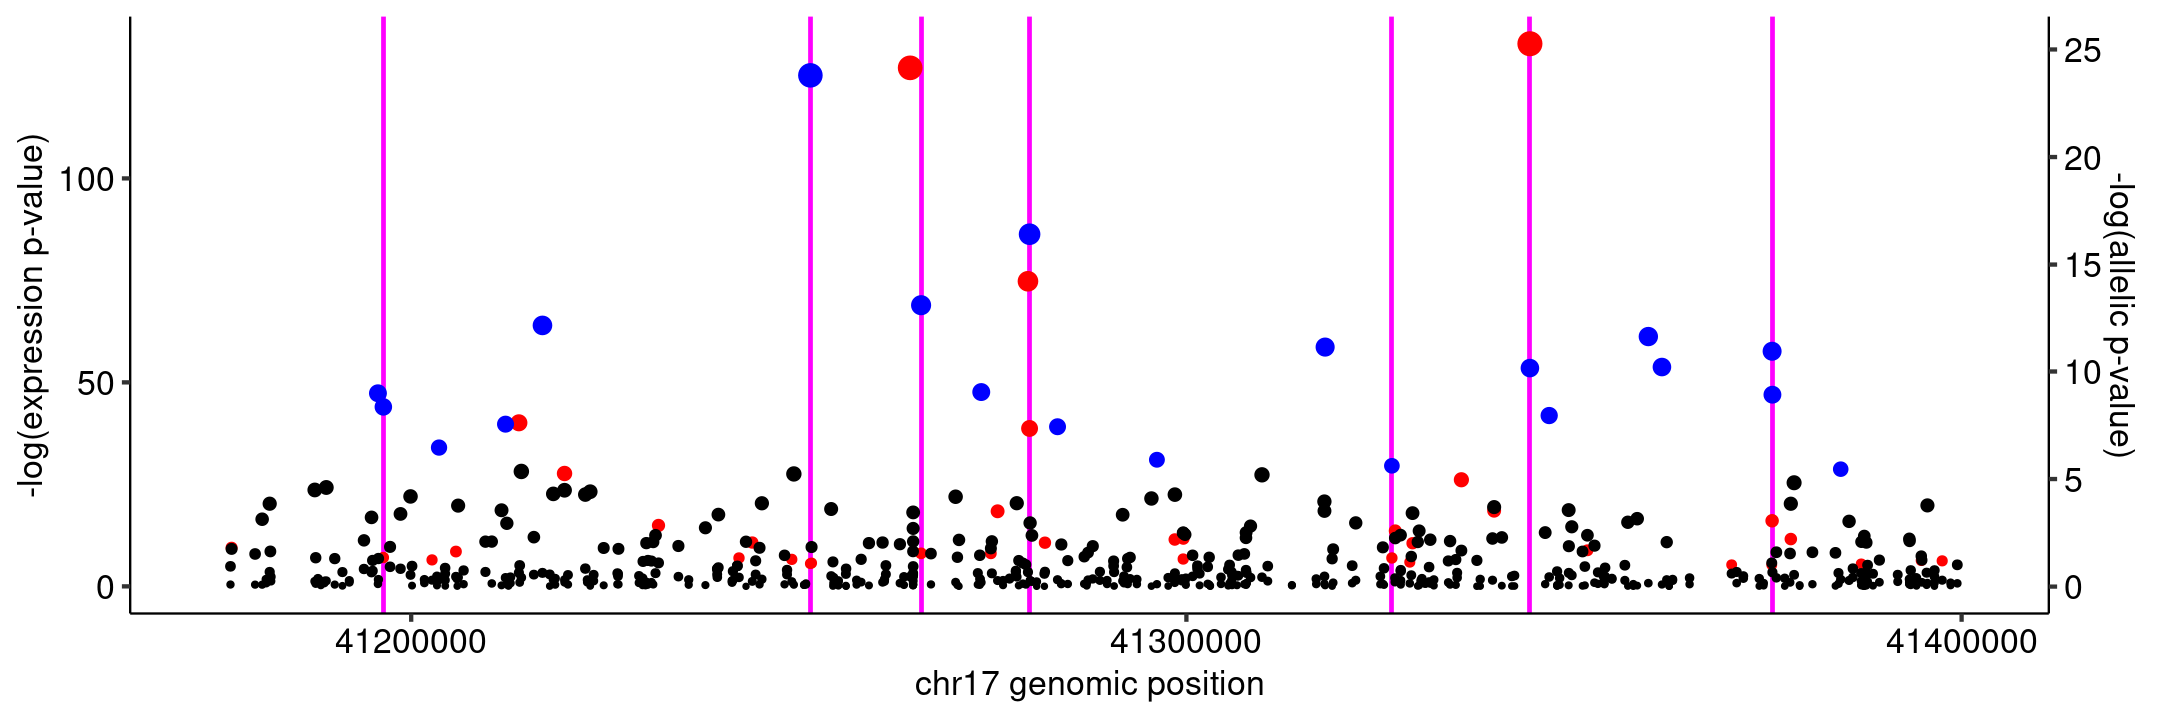

In [10]:
love = fread("sumstats/1KG_novaSeq_DESeq2_Love_Base.txt")
love = separate_rows(data = love, sep = ",",geneID)
brca1 = subset(love,geneID == "ENSG00000012048")

options(repr.plot.width = 18, repr.plot.height = 6)
coeff = 0.19
ggplot(brca1) + 
    geom_vline(xintercept = unlist(subset(brca1,padj_expr<5e-2 & padj_allele < 5e-2,select=pos)),
               color = "magenta", size = 1) +
    geom_point(aes(x = pos, y = -log(pvalue_expr),
                   size = -log(pvalue_expr),
                   color = ifelse(padj_expr < 5e-2,"red","black"))) + 
    geom_point(aes(x = pos, y = -log(pvalue_allele)/coeff,
                   size = -log(pvalue_allele)/coeff,
                   color = ifelse(padj_allele < 5e-2,"blue","black"))) + 
    theme_pubr(base_size = 20) + 
    scale_x_continuous(limits = c(41175000,41400000), breaks = c(41200000,41300000,41400000)) + scale_color_identity() +
    scale_y_continuous(name = "-log(expression p-value)",sec.axis = sec_axis(~.*coeff, name="-log(allelic p-value)")) +
    theme(legend.position = "none") + xlab("chr17 genomic position")

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


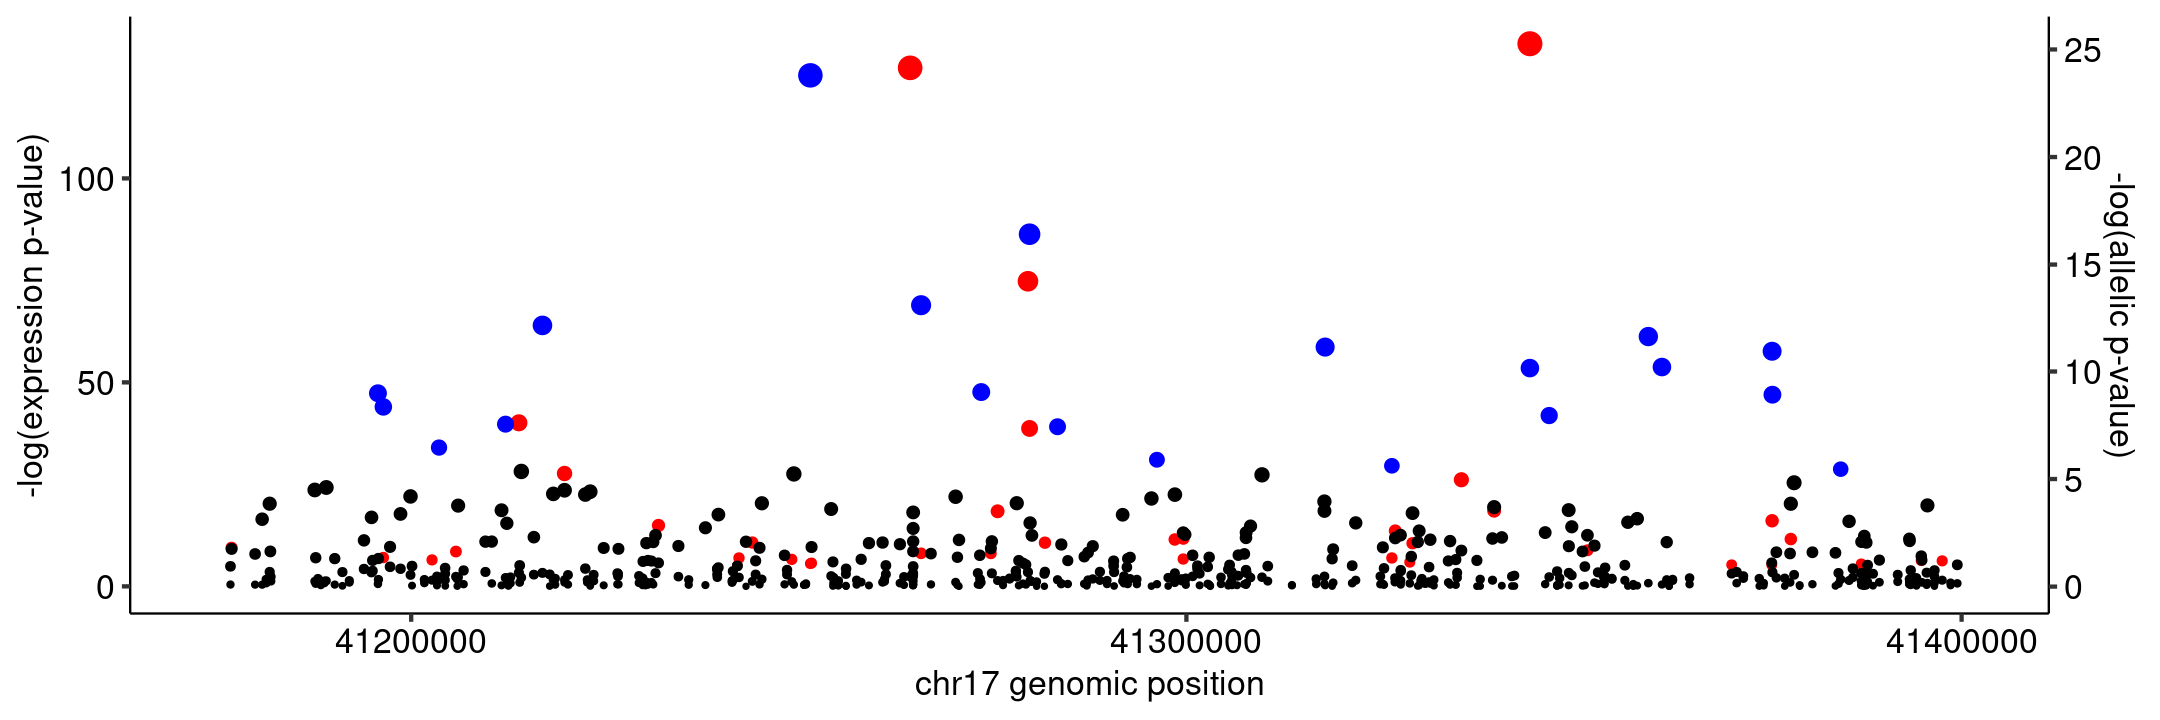

In [13]:
love = fread("sumstats/1KG_novaSeq_DESeq2_Love_Base.txt")
love = separate_rows(data = love, sep = ",",geneID)
brca1 = subset(love,geneID == "ENSG00000012048")

options(repr.plot.width = 18, repr.plot.height = 6)
coeff = 0.19
ggplot(brca1) + 
    geom_point(aes(x = pos, y = -log(pvalue_expr),
                   size = -log(pvalue_expr),
                   color = ifelse(padj_expr < 5e-2,"red","black"))) + 
    geom_point(aes(x = pos, y = -log(pvalue_allele)/coeff,
                   size = -log(pvalue_allele)/coeff,
                   color = ifelse(padj_allele < 5e-2,"blue","black"))) + 
    theme_pubr(base_size = 20) + 
    scale_x_continuous(limits = c(41175000,41400000), breaks = c(41200000,41300000,41400000)) + scale_color_identity() +
    scale_y_continuous(name = "-log(expression p-value)",sec.axis = sec_axis(~.*coeff, name="-log(allelic p-value)")) +
    theme(legend.position = "none") + xlab("chr17 genomic position")

In [14]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/libopenblas-r0.3.3.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggpubr_0.4.0                ggcorrplot_0.1.3           
 [3] patchwork_1.1.0             DESeq2_1.26.0              
 [5] SummarizedExperiment_1.16.1 DelayedArray_0.12.3        
 [7] BiocParallel_1.20.1         matrixStats_0.57.0         
 [9] Biobase_2.46.0              GenomicRanges_1.38.0       
[11] G